In [49]:
from pathlib import Path
import json

from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.data_utils import LabelledTraitData
from evaluation.evaluate_model import load_model

In [25]:
sns.set_style("white")

In [26]:
VARS = [
    'N.Percent', 'P.Percent',
    'K.Percent', 'Ca.Percent',
    'Mg.Percent', 'C.Percent',
    'Amax', 'Asat',
    'Area.cm2', 'Dry.mass.g',
    'Fresh.mass.g', 'Thickness.mm',
    'SLA.g.m2'
]

In [104]:
def qqplot(y, preds, ax, metrics, var):
    """Create a QQ plot of true vs predicted values."""
    minmax = 2.5
    r_squared = metrics['r_squared']
    mae = metrics['mae']
    i = VARS.index(var)

    quantiles = np.linspace(0.01, 0.99, 50, endpoint=True)
    y_q = np.quantile(y, quantiles)
    preds_q = np.quantile(preds, quantiles)

    sns.scatterplot(x=y_q, y=preds_q, ax=ax, alpha=0.8, s=24)
    ax.plot([-minmax, minmax], [-minmax, minmax], color='grey', linestyle='--')
    ax.set_title(f"{var} (R²: {r_squared:.2f}, MAE: {mae:.2f})")
    ax.set_xlabel("True quantiles")
    ax.set_ylabel("Predicted quantiles")
    ax.set_ylim(-minmax, minmax)
    ax.set_xlim(-minmax, minmax)

    # Set labels for last subplots in column.
    if i > 9:
        ax.set_xlabel("True quantiles")
        ax.set_xticks([-2, -1, 0, 1, 2])
    else:
        ax.set_xticklabels([])

    if i % 3 == 0:
        ax.set_ylabel("Predicted quantiles")
    else:
        ax.set_ylabel("")
        ax.set_yticklabels([])

def plot_residuals(residuals, preds, ax, metrics, var):
    """Plot residuals vs predicted values."""
    r_squared = metrics['r_squared']
    mae = metrics['mae']
    i = VARS.index(var)

    sns.scatterplot(x=preds, y=residuals, ax=ax, alpha=0.5, s=24)

    ax.set_title(f"{var} (R²: {r_squared:.2f}, MAE: {mae:.2f})")
    ax.set_ylim(-2., 2.)
    ax.set_xlim(-3.5, 3.5)

    # Set labels for last subplots in column.
    if i > 9:
        ax.set_xlabel("Predicted values")
        ax.set_xticks([-3, -2, -1, 0, 1, 2, 3])
    else:
        ax.set_xticklabels([])

    if i % 3 == 0:
        ax.set_ylabel("Residuals")
    else:
        ax.set_yticklabels([])


In [28]:
dpath = Path('/Users/campbelli/Documents/geofm-plant-traits/data')
model_rpath = Path('/Users/campbelli/Documents/geofm-plant-traits/models/')

In [110]:
model_names = [
    'rf_bands_only',
    'rf_aux_vars',
    'gbdt_bands_only',
    'gbdt_aux_vars',
    'vanilla_nn_bands_only',
    'nn_aux_vars',
    'grf_bands_only',
    'grf_aux_vars',
    'ensemble_nn_aux_vars',
    'snapshot_ensemble_aux_vars'
]

In [111]:
# Declare model type.
model_name = model_names[5]
model_name = 'grf_aux_vars'
model_path = model_rpath / f'{model_name}.py'

In [112]:
# Load trait metadata (std and mean stats).
metadata_path = dpath / 'metadata'
with open(metadata_path / 'trait_stats.json', 'r') as f:
    trait_stats = json.load(f)

In [113]:
predictions = {}
true_vals = {}
residuals = {}
metrics = {}

In [114]:
for i, var in enumerate(VARS):
    model = load_model(model_path, 42, var)
    var_stats = trait_stats[var]
    model.set_stats(var_stats)

    dataset = LabelledTraitData(
        data_path=Path('/Users/campbelli/Documents/geofm-plant-traits/data'),
        var=var
    )

    X_train, y_train = dataset.train_data, dataset.train_labels
    X_val, y_val = dataset.val_data, dataset.val_labels
    X_test, y_test = dataset.test_data, dataset.test_labels

    X_train, y_train = model.configure_data(X_train, y_train)
    X_val, y_val = model.configure_data(X_val, y_val)
    X_test, y_test = model.configure_data(X_test, y_test)
    
    # Uses optimised hyperparameters
    model.fit(X_train, y_train, X_val, y_val)
    preds = model.predict(X_test)

    # if type(preds) != np.ndarray:
    #     preds = preds.numpy().flatten()
    #     y_test = y_test.numpy().flatten()

    predictions[var] = preds
    true_vals[var] = y_test
    residuals[var] = y_test - preds
    
    preds, y_test = model.unstandardise(preds, y_test)
    metrics[var] = {
        'r_squared': r2_score(y_test, preds),
        'mae': mean_absolute_error(y_test, preds)
    }

In [115]:
for var in VARS:
    predictions[var] = predictions[var].to_numpy()
    true_vals[var] = true_vals[var].to_numpy().flatten()
    residuals[var] = predictions[var] - true_vals[var]

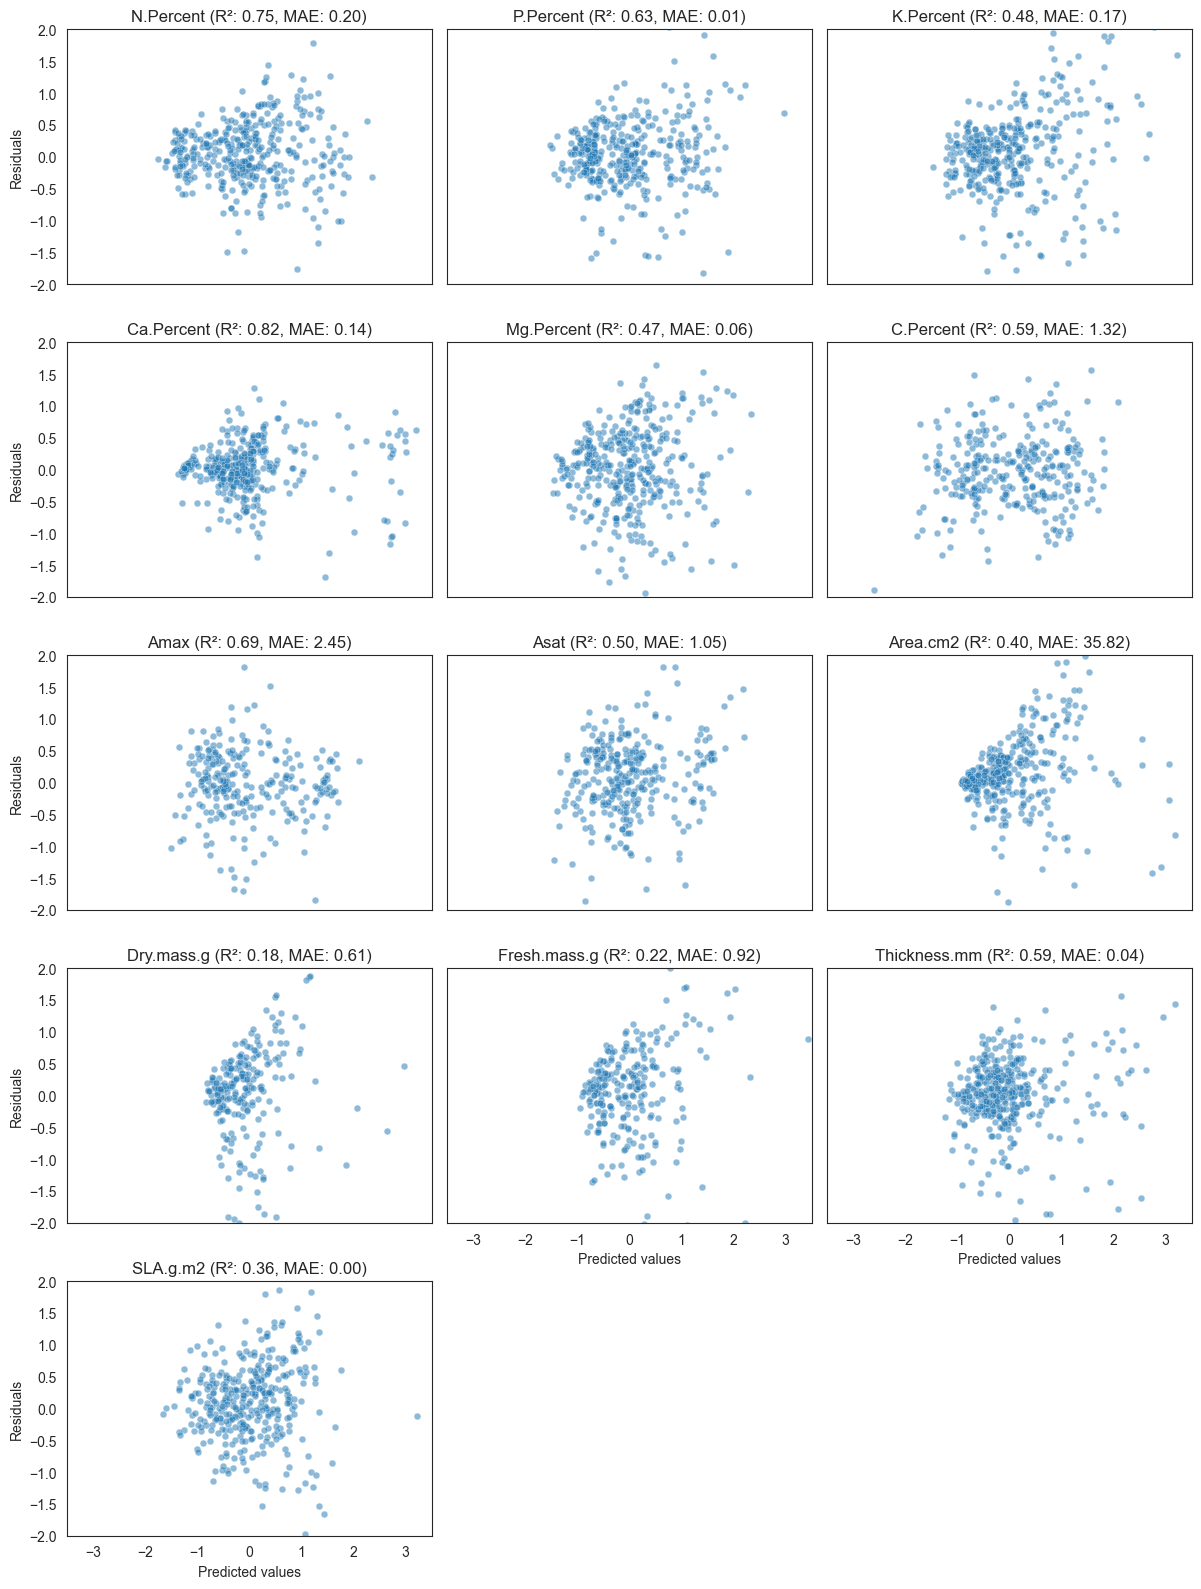

In [116]:
# Plot residuals for each different variable on a single plot
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(12, 16))

# remove empty subplots
for j in range(len(VARS), len(axes.flat)):
    axes.flat[j].remove()

for var in VARS:
    i = VARS.index(var)
    ax = axes.flat[i]
    preds = predictions[var]
    res = residuals[var]
    var_metrics = metrics[var]

    fig = plot_residuals(res, preds, ax, var_metrics, var)

# Space subplots
plt.subplots_adjust(hspace=0.2, wspace=0.2)

plt.savefig(f"../figures/models/residuals_{model_name}.png", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

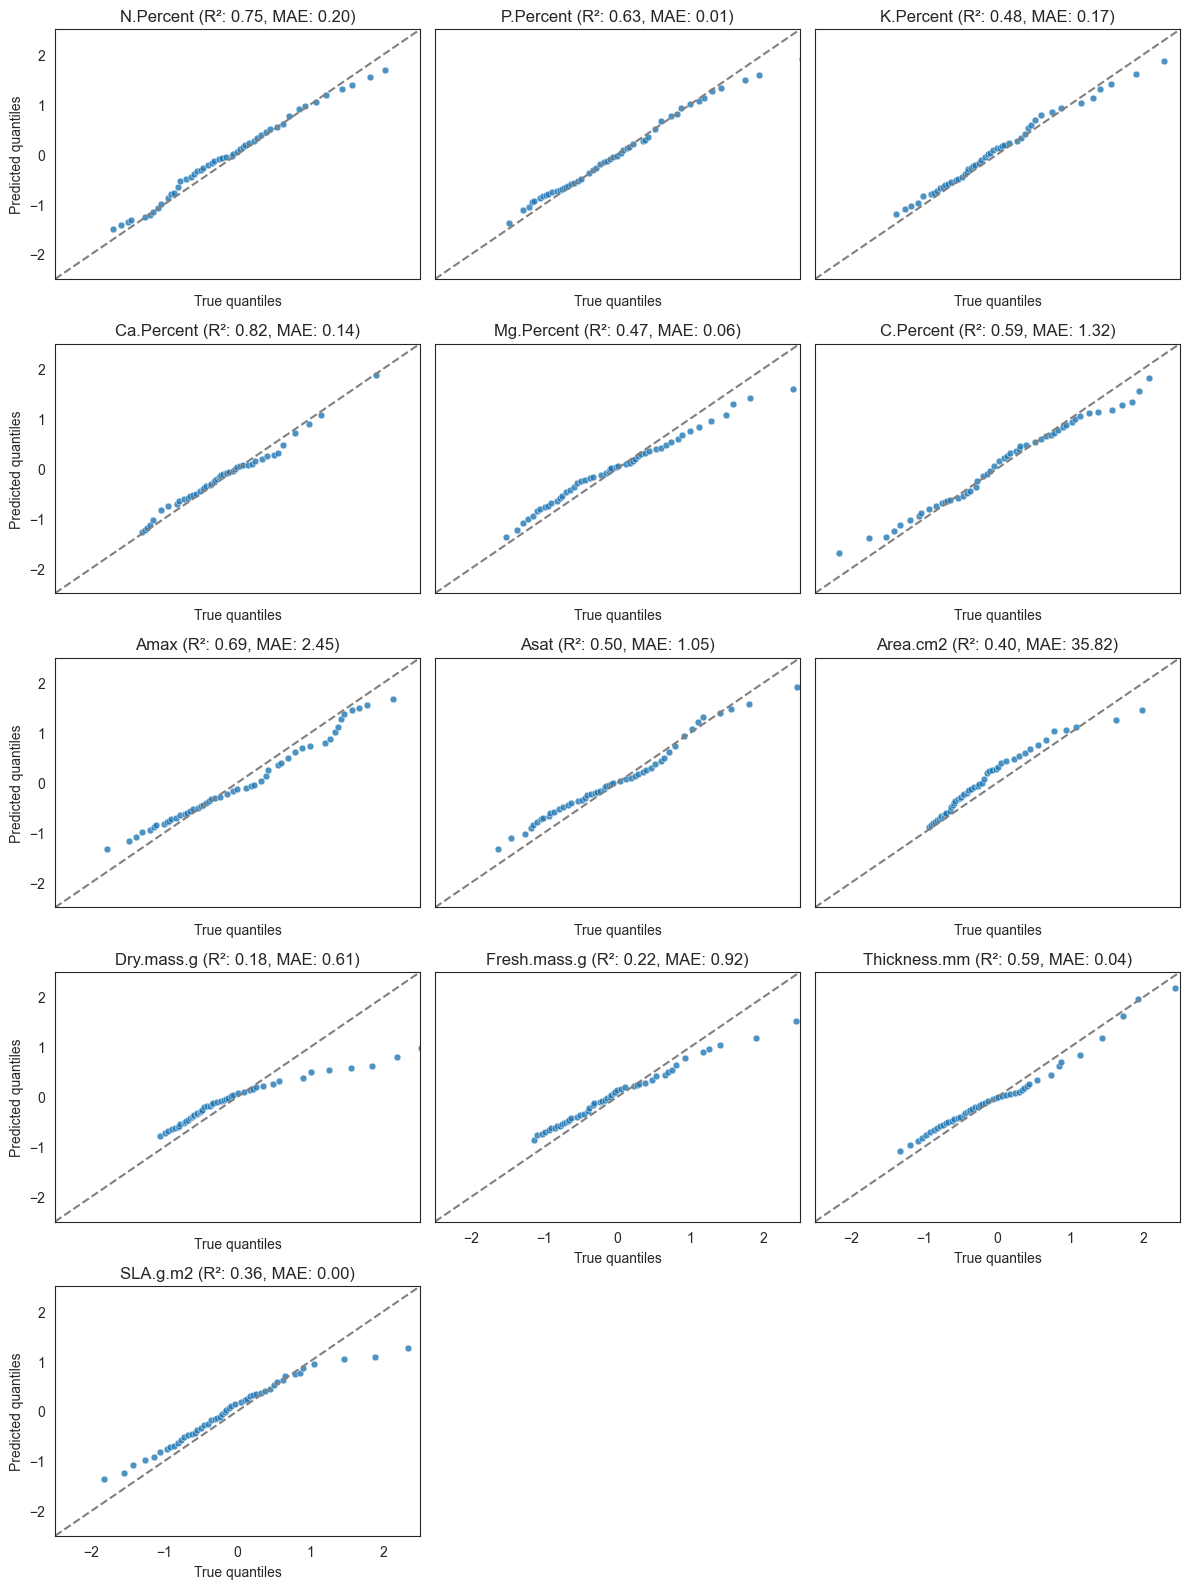

In [117]:
# Plot QQplot for each different variable on a single plot
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(12, 16))

# remove empty subplots
for j in range(len(VARS), len(axes.flat)):
    axes.flat[j].remove()

for var in VARS:
    i = VARS.index(var)
    ax = axes.flat[i]
    preds = predictions[var]
    trues = true_vals[var]
    var_metrics = metrics[var]

    fig = qqplot(trues, preds, ax, var_metrics, var)
    
# Space subplots
plt.subplots_adjust(hspace=0.3, wspace=0.2)

plt.savefig(f"../figures/models/qqplot_{model_name}.png", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()